In [3]:
from __future__ import print_function
import time
import intrinio_sdk
from intrinio_sdk.rest import ApiException
from pprint import pprint
from datetime import date
from datetime import timedelta
import io
from collections import Counter
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import pandas as pd

In [21]:
class Stock:
    def __init__(self, ticker, start_date=date.today(), end_date=date.today(), frequency='daily', page_size=100):
        intrinio_sdk.ApiClient().configuration.api_key['api_key'] = 'OmEzMWY4NDEzMzRlOGM3Y2ZjNmY3ZjAwZWRmZWI2MTIy'
        
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.frequency = frequency
        self.security_api = intrinio_sdk.SecurityApi()
        self.api_response = self.security_api.get_security_stock_prices(
            ticker, start_date=start_date, end_date=end_date, 
            frequency=frequency, page_size=int((end_date - start_date).days), next_page='')
        self.date_range_iter = self.daterange(start_date, end_date)
        self.prices = self.api_response.stock_prices_dict
        self.start_price = self.api_response.stock_prices_dict[0]['adj_close']
        self.end_price = self.api_response.stock_prices_dict[-1]['adj_close']
    
    def display_close_price(self):
        plt.title(self.ticker + " Stock Price")
        close_prices = []
        date = []
        #### CHANGED ####
        prices_df = pd.DataFrame(self.prices)
        close_prices = prices_df['adj_close']
        date = prices_df['date']
        #### CHANGED ####
        plt.plot(date, close_prices)
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.show()
#         #TODO: add start and end date arguments 
    
    def get_stock_price_dict(self):
        return self.api_response.stock_prices_dict
    
    def get_api_response(self):
        return self.api_response
    
#     def start_price(self):
#         return self.api_response.stock_prices_dict[0]['close']
    
#     def end_price(self):
#         return self.api_response.stock_prices_dict[-1]['close']
    
    def get_performance(self, start=None, end=None):
        if (start == None):
            start = self.start_date
        if (end == None):
            end = self.end_date
        
        max_ind = len(self.prices)
        curr_ind = 0
        gains = []

        for date in self.daterange(start, end):
            if ((date - self.start_date).total_seconds() < 0):
                gains.append(0)
            elif ((self.end_date - date).total_seconds() < 0):
                gains.append(0)
            elif (curr_ind >= max_ind):
                gains.append(0)
            else:
                gains.append(self.prices[curr_ind]['adj_close'] - self.start_price)
                curr_ind += 1
        return np.array(gains)
    
    def daterange(self, start_date, end_date):
        delta = timedelta(days=1)
        while start_date <= end_date:
            if (start_date.weekday() >= 5):
                start_date += delta
                continue
            yield start_date
            start_date += delta
    
    
class Portfolio:
    def __init__(self, capital=1000):
        self.capital = float(capital)
        self.holdings = {}
        
    def buy(self, ticker='', start=date.today(), end=date.today()):
        newStock = Stock(ticker, start_date=start, end_date=end)
        self.holdings[newStock] = (start, end)
    
    def display_performance(self):
        min_date = min(self.holdings.values(), key = lambda x: x[0])[0]
        max_date = max(self.holdings.values(), key = lambda x: x[1])[1]
        
        perf = np.array([self.capital] * len(list(self.daterange(min_date, max_date))))
        for i in self.holdings:
            perf += i.get_performance(start=min_date, end=max_date)
        
        plt.title("Portfolio Performance")
        plt.plot(list(self.daterange(min_date, max_date)), perf)
        plt.xlabel("Date")
        plt.ylabel("$")
        plt.show()
        #some of the logic is wrong, so that if two stocks are seperated, then jumps to 1000 which is not right
    
    def daterange(self, start_date, end_date):
        delta = timedelta(days=1)
        while start_date <= end_date:
            if (start_date.weekday() >= 5):
                start_date += delta
                continue
            yield start_date
            start_date += delta

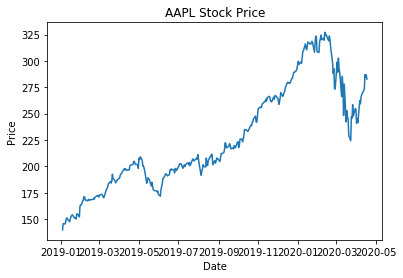

[   0.            3.89          1.63          4.25         -9.55
  -14.81        -16.73        -23.37        -20.33        -41.39
  -37.87        -41.89        -28.51        -27.99        -35.06
  -24.36        -37.28        -35.92        -58.43        -53.56
  -38.02        -36.13        -29.94        -40.59         -4.83
  -34.57         -7.37          2.54        -16.63          6.23
   10.12         19.94          6.52         16.01         -9.44
   -9.28          9.85          5.28         15.38         30.25
   37.5          40.82         36.2          42.15         42.07
   44.4          36.81         38.75         37.23         41.64
   37.88890256   35.29505858   25.12918545   25.9771729    40.30317272
   40.7720599    34.13780511   25.41849882   34.75633714   35.67415885
   34.14778143   33.02045694   35.1753427    31.69360598   27.80284001
   29.13966729   33.40953353   26.79523139   26.09688878   19.67213677
   14.88350174   16.29016328   13.92577473   16.83886104   10.1547

In [22]:
appl = Stock(ticker="AAPL", start_date=date(2019, 1, 3), end_date=date.today())
appl.display_close_price()
print(appl.get_performance())

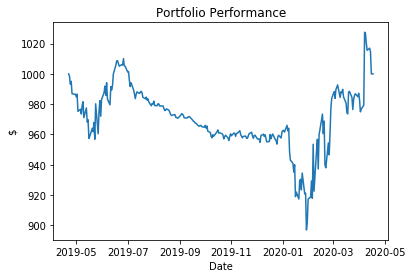

In [20]:
testport = Portfolio()
testport.buy('AAPL', start=date(2020, 1, 3))
time.sleep(61)
testport.buy('MSFT', start=date(2019, 4, 20))
testport.display_performance()